### Analysis of On-premise API Inference Results for 100 Eurosat images Notebook 

This notebook ingests .csv file containing the inference results for 100 Eurosat test images and computes the average confidence, latency, inference time. The notebook also generates visuals to interpret these metrics. 


In [8]:
# Imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import ast
import os
from dotenv import load_dotenv
load_dotenv()

# Read in .csv file saving the inference results
RESULTS_PATH = os.getenv("RESULT_CSV")
batch_df = pd.read_csv(RESULTS_PATH) # Change to path to where your results .csv file is stored 
print("Header of results for 100 test images:")
# Check header of csv file
display(batch_df.head())

# Compute average confidence over the 100 images 
avg_conf = batch_df["confidence"].mean() 
print(f"Avg_confidence for 100 test images:{avg_conf:.2f}")

# Compute average full end-to-end API latency_ms over the 100 images
# This is total time for file upload, file save, inference, DB insert, JSON serialization, and network return 
avg_latency = batch_df["latency_ms"].mean()
print(f"Avg_latency (ms) for 100 test images: {avg_latency:.2f} ms")

# Compute average inference_ms over the 100 images
# This is the time taken to complete a forward pass and generate a prediction)
avg_inference = batch_df["inference_ms"].mean() 
print(f"Avg_inference (ms) for 100 test images: {avg_inference:.2f} ms")

# Convert string to dictionary
batch_df["resources"] = batch_df["resources"].apply(ast.literal_eval)

# Then extract values
cpu_usage = batch_df["resources"].apply(lambda x: x["cpu_percent"]).mean()
print(f"Avg CPU usage for 100 test images: {cpu_usage:.2f}%")

memory_percent = batch_df["resources"].apply(lambda x: x["memory_percent"]).mean()
print(f"Avg Memory usage for 100 test images: {memory_percent:.2f}%")

memory_used_mb = batch_df["resources"].apply(lambda x: x["memory_used_mb"]).mean()
print(f"Avg Memory used for 100 test images: {memory_used_mb:.2f} MB")


Header of results for 100 test images:


,confidence,created_at,filename,inference_ms,latency_ms,predicted_label,prediction_id,resources,true_label
0,0.999847,2025-12-02T02:14:46.437298,20251202_021446_AnnualCrop_1275.jpg,17.31,17.95,AnnualCrop,402,"{'cpu_percent': 0.0, 'memory_percent': 73.6, '...",AnnualCrop
1,0.996145,2025-12-02T02:14:46.560062,20251202_021446_Residential_504.jpg,10.71,11.08,Residential,403,"{'cpu_percent': 0.0, 'memory_percent': 73.6, '...",Residential
2,0.904147,2025-12-02T02:14:46.683046,20251202_021446_Pasture_787.jpg,9.04,9.22,Pasture,404,"{'cpu_percent': 17.2, 'memory_percent': 73.6, ...",Pasture
3,0.999996,2025-12-02T02:14:46.819482,20251202_021446_Residential_1575.jpg,20.68,21.37,Residential,405,"{'cpu_percent': 12.3, 'memory_percent': 73.6, ...",Residential
4,0.999982,2025-12-02T02:14:46.955517,20251202_021446_Pasture_473.jpg,20.81,21.80,Pasture,406,"{'cpu_percent': 20.0, 'memory_percent': 73.6, ...",Pasture


Avg_confidence for 100 test images:0.99
Avg_latency (ms) for 100 test images: 17.74 ms
Avg_inference (ms) for 100 test images: 17.02 ms
Avg CPU usage for 100 test images: 4.56%
Avg Memory usage for 100 test images: 72.89%
Avg Memory used for 100 test images: 7189.60 MB


### Plot Latency (ms) vs. Timestamp 

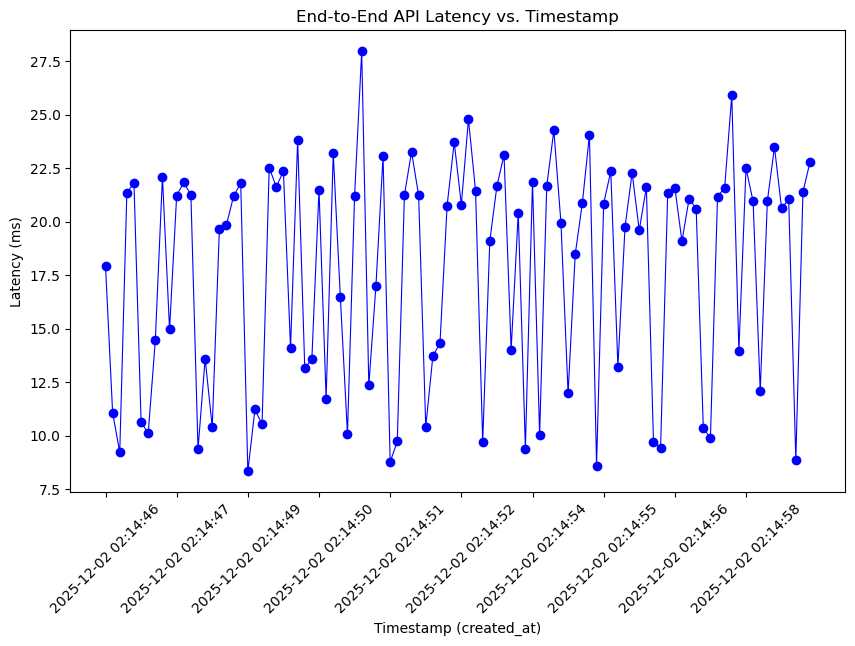

In [9]:
# Plotting latency_ms vs.timestamp 

fig = plt.figure(figsize=(10,6))

# Add an axes object to the figure
ax = fig.add_subplot(111)

batch_df["created_at"] = pd.to_datetime(batch_df["created_at"])
# Plot all data 
plt.plot(batch_df.index, batch_df["latency_ms"], color="blue", marker='o', linewidth=0.8)

# Use index for x-axis 
ax= plt.gca() 

# Plot only every other 10th timestamp for clean visual 
ax.set_xticks(batch_df.index[::10])
ax.set_xticklabels(batch_df["created_at"].dt.strftime("%Y-%m-%d %H:%M:%S")[::10], rotation=45)

plt.xlabel("Timestamp (created_at)")
plt.ylabel("Latency (ms)")
plt.title("End-to-End API Latency vs. Timestamp")
plt.show()

## Performance Metrics Visualization


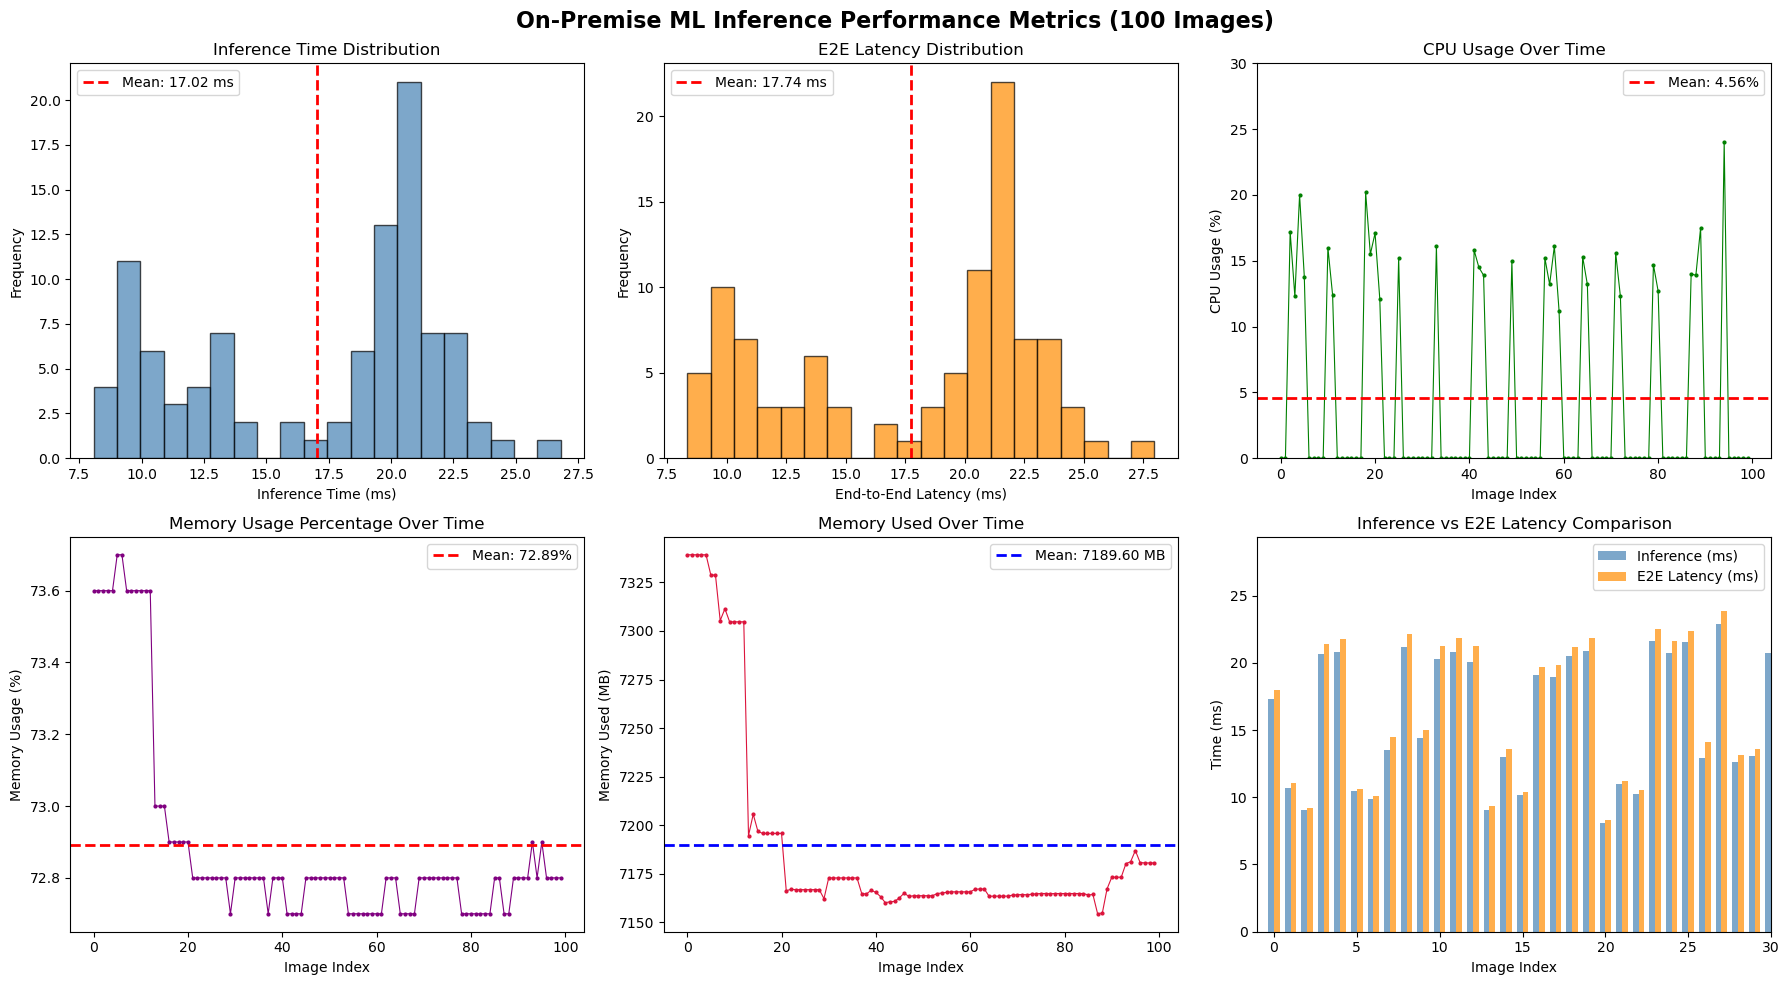

Figure saved as 'performance_metrics_overview.png'


In [10]:
# Extract resource metrics into separate columns for easier plotting
batch_df["cpu_percent"] = batch_df["resources"].apply(lambda x: x["cpu_percent"])
batch_df["memory_percent"] = batch_df["resources"].apply(lambda x: x["memory_percent"])
batch_df["memory_used_mb"] = batch_df["resources"].apply(lambda x: x["memory_used_mb"])

# Create a comprehensive figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("On-Premise ML Inference Performance Metrics (100 Images)", fontsize=16, fontweight='bold')

# 1. Inference Time Distribution (Histogram)
ax1 = axes[0, 0]
ax1.hist(batch_df["inference_ms"], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(batch_df["inference_ms"].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {batch_df["inference_ms"].mean():.2f} ms')
ax1.set_xlabel("Inference Time (ms)")
ax1.set_ylabel("Frequency")
ax1.set_title("Inference Time Distribution")
ax1.legend()

# 2. Latency Distribution (Histogram)
ax2 = axes[0, 1]
ax2.hist(batch_df["latency_ms"], bins=20, color='darkorange', edgecolor='black', alpha=0.7)
ax2.axvline(batch_df["latency_ms"].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {batch_df["latency_ms"].mean():.2f} ms')
ax2.set_xlabel("End-to-End Latency (ms)")
ax2.set_ylabel("Frequency")
ax2.set_title("E2E Latency Distribution")
ax2.legend()

# 3. CPU Usage Over Time
ax3 = axes[0, 2]
ax3.plot(batch_df.index, batch_df["cpu_percent"], color='green', marker='.', linewidth=0.8, markersize=4)
ax3.axhline(batch_df["cpu_percent"].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {batch_df["cpu_percent"].mean():.2f}%')
ax3.set_xlabel("Image Index")
ax3.set_ylabel("CPU Usage (%)")
ax3.set_title("CPU Usage Over Time")
ax3.legend()
ax3.set_ylim(0, max(batch_df["cpu_percent"].max() * 1.2, 30))

# 4. Memory Usage Percentage Over Time
ax4 = axes[1, 0]
ax4.plot(batch_df.index, batch_df["memory_percent"], color='purple', marker='.', linewidth=0.8, markersize=4)
ax4.axhline(batch_df["memory_percent"].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {batch_df["memory_percent"].mean():.2f}%')
ax4.set_xlabel("Image Index")
ax4.set_ylabel("Memory Usage (%)")
ax4.set_title("Memory Usage Percentage Over Time")
ax4.legend()

# 5. Memory Used (MB) Over Time
ax5 = axes[1, 1]
ax5.plot(batch_df.index, batch_df["memory_used_mb"], color='crimson', marker='.', linewidth=0.8, markersize=4)
ax5.axhline(batch_df["memory_used_mb"].mean(), color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {batch_df["memory_used_mb"].mean():.2f} MB')
ax5.set_xlabel("Image Index")
ax5.set_ylabel("Memory Used (MB)")
ax5.set_title("Memory Used Over Time")
ax5.legend()

# 6. Inference vs Latency Comparison
ax6 = axes[1, 2]
x = np.arange(len(batch_df))
width = 0.35
bars1 = ax6.bar(x - width/2, batch_df["inference_ms"], width, label='Inference (ms)', color='steelblue', alpha=0.7)
bars2 = ax6.bar(x + width/2, batch_df["latency_ms"], width, label='E2E Latency (ms)', color='darkorange', alpha=0.7)
ax6.set_xlabel("Image Index")
ax6.set_ylabel("Time (ms)")
ax6.set_title("Inference vs E2E Latency Comparison")
ax6.legend()
ax6.set_xlim(-1, 30)  # Show first 30 images for clarity

plt.tight_layout()
plt.savefig("performance_metrics_overview.png", dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'performance_metrics_overview.png'")


## Box Plots for All Metrics


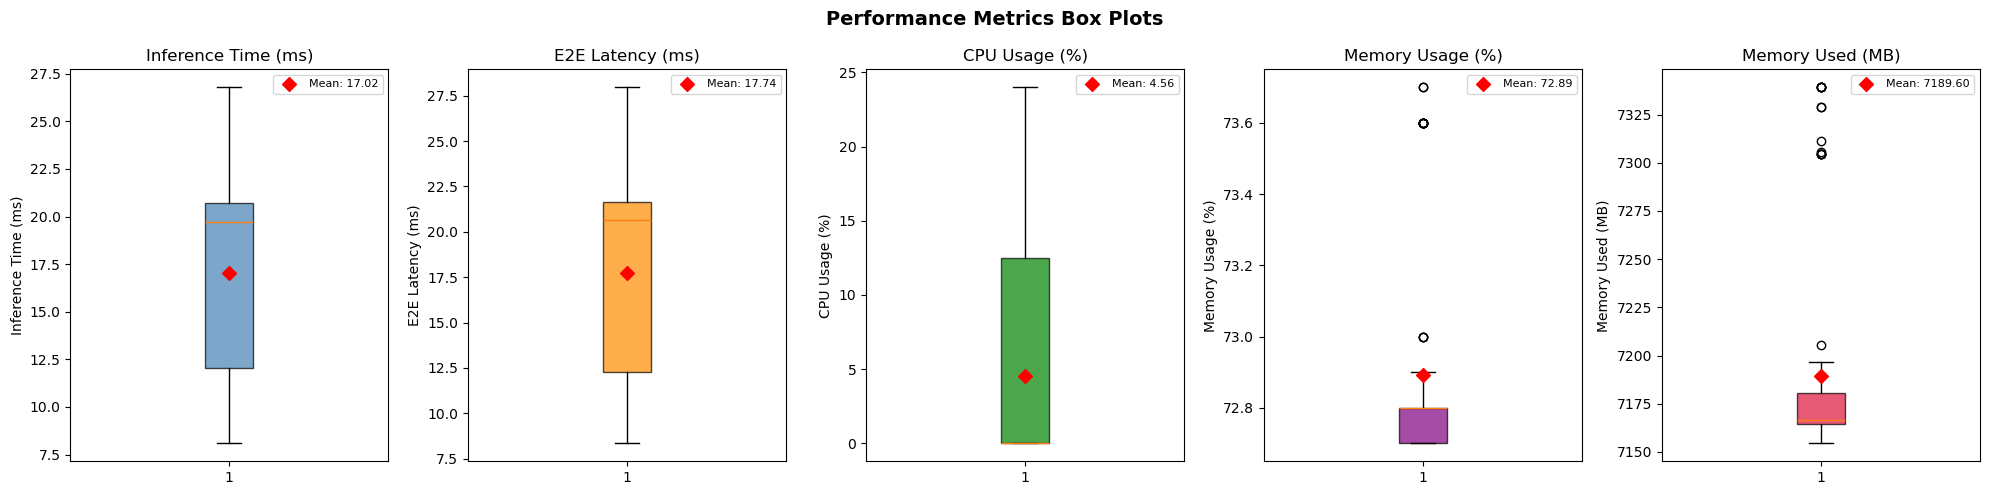

Figure saved as 'metrics_boxplots.png'


In [11]:
# Box plots for all metrics
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle("Performance Metrics Box Plots", fontsize=14, fontweight='bold')

# Box plot data and labels
metrics = [
    (batch_df["inference_ms"], "Inference Time (ms)", "steelblue"),
    (batch_df["latency_ms"], "E2E Latency (ms)", "darkorange"),
    (batch_df["cpu_percent"], "CPU Usage (%)", "green"),
    (batch_df["memory_percent"], "Memory Usage (%)", "purple"),
    (batch_df["memory_used_mb"], "Memory Used (MB)", "crimson")
]

for i, (data, label, color) in enumerate(metrics):
    bp = axes[i].boxplot(data, patch_artist=True)
    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][0].set_alpha(0.7)
    axes[i].set_ylabel(label)
    axes[i].set_title(label)
    # Add mean marker
    axes[i].scatter([1], [data.mean()], color='red', marker='D', s=50, zorder=3, label=f'Mean: {data.mean():.2f}')
    axes[i].legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig("metrics_boxplots.png", dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved as 'metrics_boxplots.png'")


## Summary Statistics Table


In [12]:
# Create a summary statistics table
summary_data = {
    'Metric': ['Inference Time (ms)', 'E2E Latency (ms)', 'CPU Usage (%)', 'Memory Usage (%)', 'Memory Used (MB)'],
    'Mean': [
        batch_df["inference_ms"].mean(),
        batch_df["latency_ms"].mean(),
        batch_df["cpu_percent"].mean(),
        batch_df["memory_percent"].mean(),
        batch_df["memory_used_mb"].mean()
    ],
    'Std': [
        batch_df["inference_ms"].std(),
        batch_df["latency_ms"].std(),
        batch_df["cpu_percent"].std(),
        batch_df["memory_percent"].std(),
        batch_df["memory_used_mb"].std()
    ],
    'Min': [
        batch_df["inference_ms"].min(),
        batch_df["latency_ms"].min(),
        batch_df["cpu_percent"].min(),
        batch_df["memory_percent"].min(),
        batch_df["memory_used_mb"].min()
    ],
    'Max': [
        batch_df["inference_ms"].max(),
        batch_df["latency_ms"].max(),
        batch_df["cpu_percent"].max(),
        batch_df["memory_percent"].max(),
        batch_df["memory_used_mb"].max()
    ],
    'Median': [
        batch_df["inference_ms"].median(),
        batch_df["latency_ms"].median(),
        batch_df["cpu_percent"].median(),
        batch_df["memory_percent"].median(),
        batch_df["memory_used_mb"].median()
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

print("=" * 80)
print("PERFORMANCE METRICS SUMMARY (100 Images)")
print("=" * 80)
display(summary_df)

# Save summary to CSV
summary_df.to_csv("performance_summary.csv", index=False)
print("\nSummary saved to 'performance_summary.csv'")


PERFORMANCE METRICS SUMMARY (100 Images)


,Metric,Mean,Std,Min,Max,Median
0,Inference Time (ms),17.02,5.04,8.08,26.80,19.70
1,E2E Latency (ms),17.74,5.33,8.34,27.97,20.62
2,CPU Usage (%),4.56,7.15,0.00,24.00,0.00
3,Memory Usage (%),72.89,0.29,72.70,73.70,72.80
4,Memory Used (MB),7189.60,52.75,7154.41,7339.23,7166.41



Summary saved to 'performance_summary.csv'


## Latency Over Time (Line Chart)


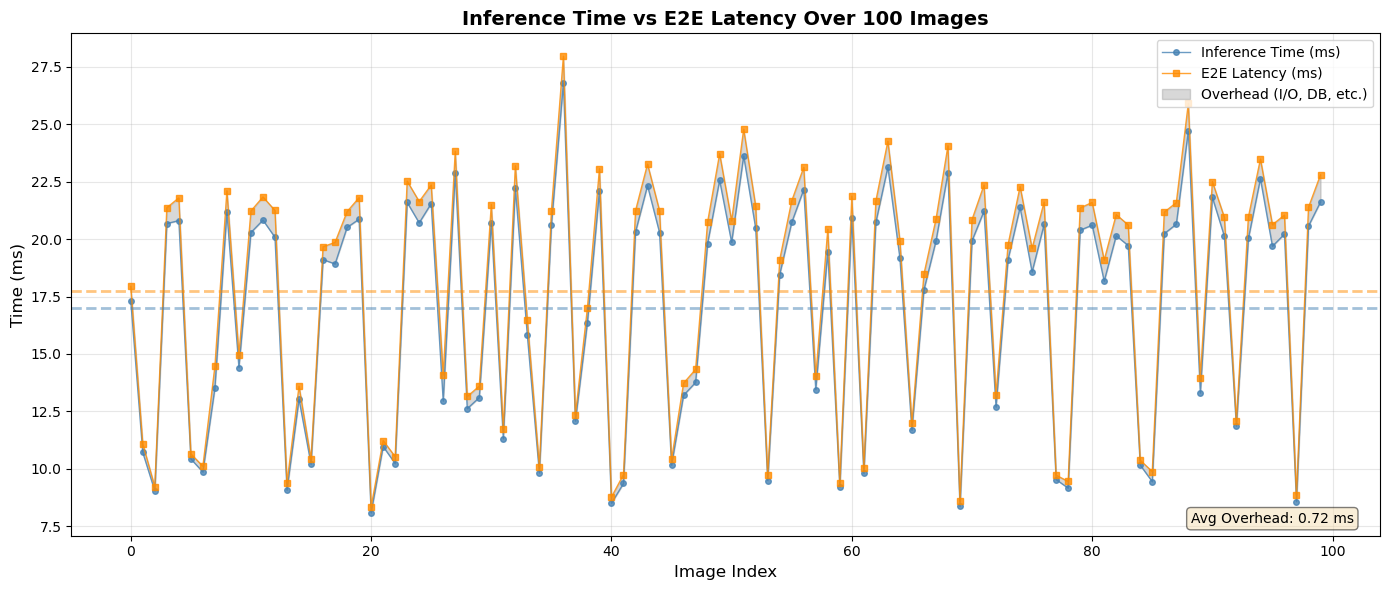


Average Inference Time: 17.02 ms
Average E2E Latency: 17.74 ms
Average Overhead (I/O, DB, etc.): 0.72 ms (4.0% of total latency)


In [13]:
# Detailed latency comparison over time
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(batch_df.index, batch_df["inference_ms"], color='steelblue', marker='o', 
        linewidth=1, markersize=4, label='Inference Time (ms)', alpha=0.8)
ax.plot(batch_df.index, batch_df["latency_ms"], color='darkorange', marker='s', 
        linewidth=1, markersize=4, label='E2E Latency (ms)', alpha=0.8)

# Add mean lines
ax.axhline(batch_df["inference_ms"].mean(), color='steelblue', linestyle='--', linewidth=2, alpha=0.5)
ax.axhline(batch_df["latency_ms"].mean(), color='darkorange', linestyle='--', linewidth=2, alpha=0.5)

# Fill the area between inference and latency (overhead visualization)
ax.fill_between(batch_df.index, batch_df["inference_ms"], batch_df["latency_ms"], 
                alpha=0.3, color='gray', label='Overhead (I/O, DB, etc.)')

ax.set_xlabel("Image Index", fontsize=12)
ax.set_ylabel("Time (ms)", fontsize=12)
ax.set_title("Inference Time vs E2E Latency Over 100 Images", fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Add text annotation for average overhead
avg_overhead = batch_df["latency_ms"].mean() - batch_df["inference_ms"].mean()
ax.text(0.98, 0.02, f'Avg Overhead: {avg_overhead:.2f} ms', 
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom', 
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig("latency_over_time.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAverage Inference Time: {batch_df['inference_ms'].mean():.2f} ms")
print(f"Average E2E Latency: {batch_df['latency_ms'].mean():.2f} ms")
print(f"Average Overhead (I/O, DB, etc.): {avg_overhead:.2f} ms ({avg_overhead/batch_df['latency_ms'].mean()*100:.1f}% of total latency)")


## Resource Usage Combined Chart


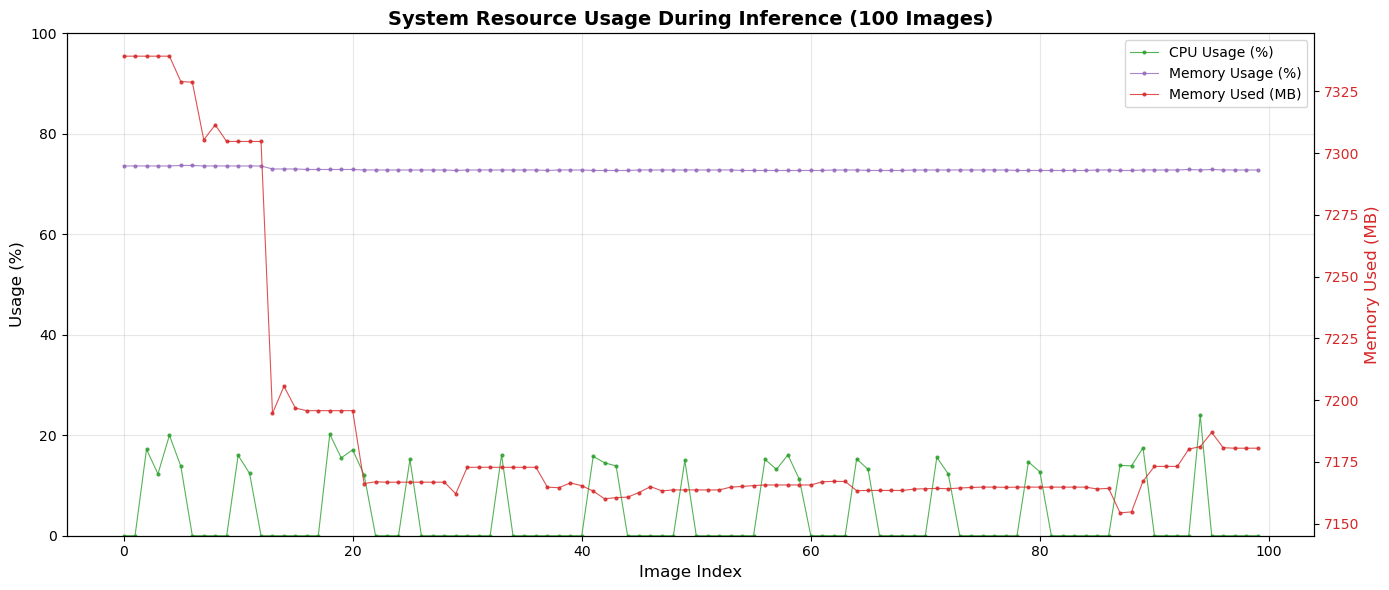


Resource Usage Summary:
  CPU Usage: 4.56% (avg), 24.00% (max)
  Memory %:  72.89% (avg), 73.70% (max)
  Memory MB: 7189.60 MB (avg), 7339.23 MB (max)


In [14]:
# Resource usage combined visualization
fig, ax1 = plt.subplots(figsize=(14, 6))

# CPU and Memory percentage on left y-axis
color1 = 'tab:green'
color2 = 'tab:purple'
ax1.set_xlabel('Image Index', fontsize=12)
ax1.set_ylabel('Usage (%)', fontsize=12)

line1 = ax1.plot(batch_df.index, batch_df["cpu_percent"], color=color1, marker='.', 
                 linewidth=0.8, markersize=4, label='CPU Usage (%)', alpha=0.8)
line2 = ax1.plot(batch_df.index, batch_df["memory_percent"], color=color2, marker='.', 
                 linewidth=0.8, markersize=4, label='Memory Usage (%)', alpha=0.8)
ax1.tick_params(axis='y')
ax1.set_ylim(0, 100)

# Memory used (MB) on right y-axis
ax2 = ax1.twinx()
color3 = 'tab:red'
ax2.set_ylabel('Memory Used (MB)', fontsize=12, color=color3)
line3 = ax2.plot(batch_df.index, batch_df["memory_used_mb"], color=color3, marker='.', 
                 linewidth=0.8, markersize=4, label='Memory Used (MB)', alpha=0.8)
ax2.tick_params(axis='y', labelcolor=color3)

# Combine legends
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

ax1.set_title('System Resource Usage During Inference (100 Images)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("resource_usage.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\nResource Usage Summary:")
print(f"  CPU Usage: {batch_df['cpu_percent'].mean():.2f}% (avg), {batch_df['cpu_percent'].max():.2f}% (max)")
print(f"  Memory %:  {batch_df['memory_percent'].mean():.2f}% (avg), {batch_df['memory_percent'].max():.2f}% (max)")
print(f"  Memory MB: {batch_df['memory_used_mb'].mean():.2f} MB (avg), {batch_df['memory_used_mb'].max():.2f} MB (max)")
